In [5]:
## imports
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import matplotlib
from matplotlib import cm
import h5py
import os
from math import pi, sqrt
from scipy.optimize import curve_fit
import scipy
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from scipy.signal import argrelextrema
from math import pi, sqrt
import qnm

rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3



In [178]:
## Download QNM code
import os, ssl
## bypass the verification
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context
qnm.download_data()
ksc = qnm.cached.KerrSeqCache(init_schw=True) # Only need init_schw once

Destination path /Users/mokounkova/Library/Python/3.7/lib/python/site-packages/qnm/data.tar.bz2 already exists, use overwrite=True to force an overwrite.


In [6]:
## GW150914 run parameters
## Independent of the physical theory we're using
t_merger = 2533.8 ## from the simulation, useful for instantaneous regime of validity and other quantities on 
## the computational domain

## Physical run parameters
mfinal = 9.5249732342176741e-01
spin_final = 6.9174874651649620e-01 
mode = (2,2) ## mode that we are interested in
chi_1 = 0.33
chi_2 = -0.44


B = 0.1 ## B factor for the runs
const_ramp_time = 250
mode = (2,2) ## dominant mode for analysis

In [7]:
## Data locations

data_dir = '/Users/mokounkova/EDGB_Data/'
extrap_dir = 'BBH_SKS_d13_q1.22_sA_0_0_0.330_sB_0_0_-0.440/'

def ev_dir(start_time, ramp_time=const_ramp_time, lev=0):
    """ Returns the data directory """
    return data_dir + str(start_time) + '_' + str(ramp_time) + '/Ev/JoinedLev' + str(lev) + '/'

def ex_dir(start_time, ramp_time=const_ramp_time, lev=0):
    """ Returns the data directory """
    return data_dir + str(start_time) + '_' + str(ramp_time) + '/' + extrap_dir + 'Lev' + str(lev) + '/'

def bev_dir(lev=0):
    return data_dir + 'Background/Ev/JoinedLev' + str(lev) + '/'

def bex_dir(lev=0):
    return data_dir + 'Background/' + extrap_dir + 'Lev' + str(lev) + '/'

In [8]:
## Data reading functions

def GetWaveformRadius(rad):
    psi4_file = bev_dir() + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5'
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[rad]
    coord_radius = f[radius]['CoordRadius.dat'][0][1]
    return coord_radius
    
def GetPsi4Mode(p, radius=-1, mode=mode): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetPsi4ModeExtrapolated(p, mode=mode): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMPsi4_Asymptotic_GeometricUnits.h5' 
    print(l,m)
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def hPsi4Factor(hPsi4):
    """ h^{(2)}_{ab} -> need to divide by B^2, since the metric comes in at alpha^2, 
        and anywhere we have seen an alpha, we have put a B """
    hPsi4 = hPsi4 / B**2
    return hPsi4

def GethPsi4Mode(p, radius=-1, mode=mode): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rDeltaPsi4_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    hPsi4 = re + 1j*im
    return time, hPsi4Factor(hPsi4)

def GethPsi4ModeExtrapolated(p, mode=mode): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMDeltaPsi4_Asymptotic_GeometricUnits.h5' 
    print(l,m)
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    hPsi4 = re + 1j*im
    return time, hPsi4Factor(hPsi4)

def KGFactor(KG):
    """ Need to divide by B, since it comes in at alpha, 
        and anywhere we have had an alpha, we have put a B
        Don't need to need to introduce any additional factors
        in order to be consistent with Helvi paper """
    ## Also need to divide by B (since it's at order l^2)
    KG = KG / B
    return KG

def GetKGMode(p, mode, radius=0):
    l = mode[0]
    m = mode[1]
    def getVarMode(dataset, varname, l, m):
        """ Get mode from .h5 file containing modes. 
        Returns Re and Im parts for (l,m) mode
        of varname in dataset"""
        legend = dataset.attrs['Legend'].tolist()
        legend = [b.decode("utf-8") for b in legend]
        indexRe = legend.index(varname + '_Re(' + str(l) + ',' + str(m) + ')')
        indexIm = legend.index(varname + '_Im(' + str(l) + ',' + str(m) + ')')
        # Flip the sign since we simulated a field which is positive in +z with
        # Pontryagin negative on +z. In order to agree with mu having a minus sign
        # and the evolution equation being box field = + Pontryagin,
        # we must flip the data from the simulations 
        return -1.0 * (dataset[:,indexRe] + 1j * dataset[:,indexIm])
    KG_file = p + 'KGPsiKGRad'+str(radius) + '.h5'
    f = h5py.File(KG_file, 'r')
    dataset = f['KGPsi.dat']
    data = getVarMode(dataset, 'KGPsi', l, m)
    ## multiply the mode by the radius
    #rad = GetWaveformRadius(radius)
    #data = data * rad
    time = dataset[:,0]
    return time, KGFactor(data)

## Define colors for each data piece
ColorsDict = {GetPsi4Mode:'#70abc5', GetPsi4ModeExtrapolated:'#70abc5', \
          GethPsi4Mode:'#cc0066', GethPsi4ModeExtrapolated:'#cc0066', \
          GetKGMode:'#00cc99'}  

## Define a label for each piece
LabelsDict = {GetPsi4Mode:'$r\Psi_4^{(0)}$ ', GetPsi4ModeExtrapolated:'$r\Psi_4^{(0)}$ ', \
          GethPsi4Mode:r'$(\alpha/\sqrt{GM})^{-2} r\Psi_4^{(2)}$ ', \
          GethPsi4ModeExtrapolated:r'$(\alpha/\sqrt{GM})^{-2} r\Psi_4^{(2)}$ ', \
          GetKGMode:r'$(\alpha/\sqrt{GM})^{-1} r\vartheta^{(1)}$ '} 

In [9]:
## Data helper functions

def CutTimes(time, data, TLow, TUp): ###
    TLowIndex = np.where(time >= TLow)[0][0]
    TUpIndex = np.where(time <= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def GetPeakTimeMode(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def GetPeakTimeModeReal(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.real(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def SubtractPeakTimeModeReal(time, data): ###
    t_peak = GetPeakTimeModeReal(time, data)
    return time - t_peak


def AmpPhase(time, data): ###
    """ Return the amplitude and phase, given complex data """
    amp = np.absolute(data)
    phase = np.angle(data)
    phase = -np.unwrap(phase)
    return amp, phase

def Freq(time, data):
    """ Return the frequency as the gradient of the phase, given complex data """
    amp = np.absolute(data)
    phase = np.angle(data)
    phase = -np.unwrap(phase)
    freq = np.gradient(phase, time)
    return freq

def InterpolateTimes(time, data, time_dest):
    """ Interpolates time, data onto new time axis
        time_dest """
    interpolant = scipy.interpolate.CubicSpline(time, data)
    return interpolant(time_dest)

/Users/mokounkova/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


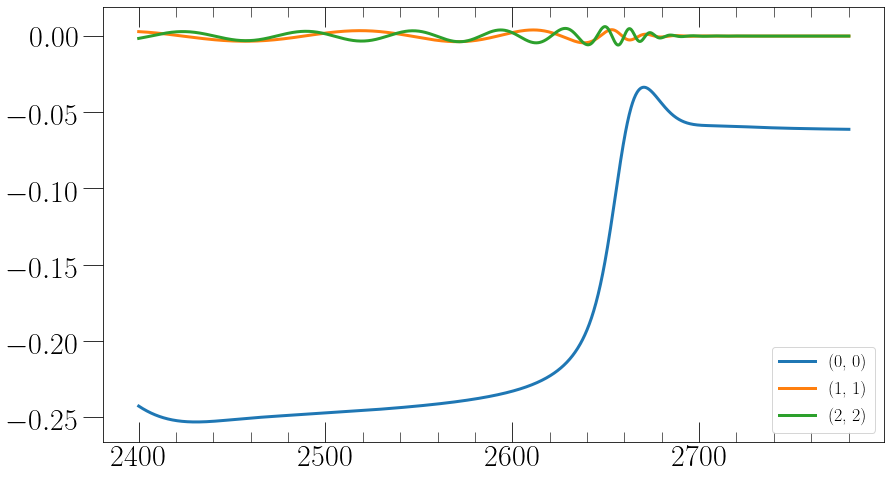

In [12]:
## Scalar field progress
plt.figure(figsize=(14, 8))

for mode in [(0,0),(1,1), (2,2)]:
    time, data = GetKGMode(ev_dir(2100),mode=mode, radius=0)
    time, data = CutTimes(time, data, 2400, 2800)
    plt.plot(time, data, label=mode)
    
plt.legend()
plt.show()

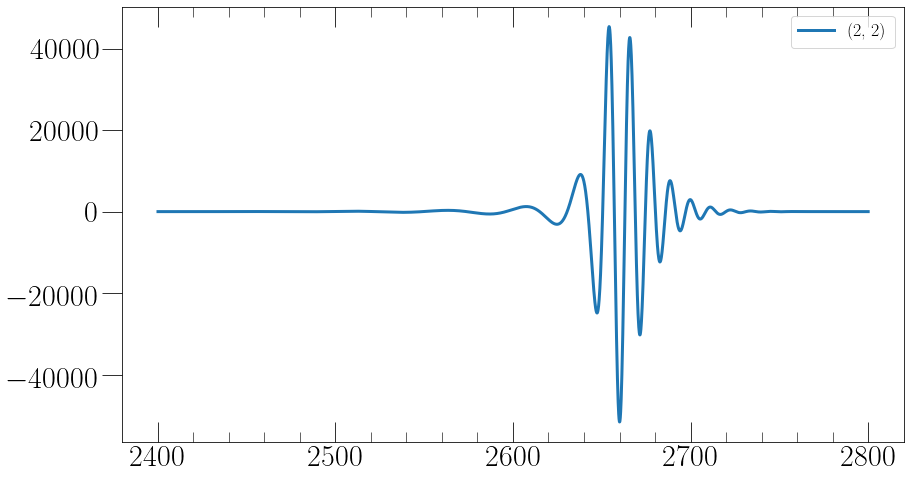

In [39]:
## Run Progress
plt.figure(figsize=(14, 8))

for mode in [(2,2)]:
    time, data = GethPsi4Mode(ev_dir(2100, lev=0),mode=mode, radius=0)
    time, data = CutTimes(time, data, 2400, 2800)
    plt.plot(time, data, label=mode)
    
plt.legend()
plt.show()


In [ ]:
## Background plot
def BackgroundPlot(): 

    figname = 'Psi4'
        
    f = plt.figure(figsize=(16,7))
    gs = gridspec.GridSpec(1, 2,width_ratios=[1.5,1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    start = -500
    mid = -40
    end = 100
    
    time, data = GetPsi4ModeExtrapolated(bex_dir())
    time = SubtractPeakTimeMode(time, data)
    time1, data1 = CutTimes(time, data, start, mid)
    time2, data2 = CutTimes(time, data, mid, end)
    
    #et, amplitude_envelope, phase, freq = AmpPhaseFreq(time, data)
    #for ax in [ax1, ax2]:
        #ax.plot(et, amplitude_envelope, color='blue', lw=2.0, ls='-', alpha=1.0)
        
    ax1.plot(time1, np.real(data1), color = ColorsDict[GetPsi4ModeExtrapolated], label='Re',lw=3.0)
    ax2.plot(time2, np.real(data2), color = ColorsDict[GetPsi4ModeExtrapolated], label='Re',lw=3.0)
    
    ax1.set_ylim(min(np.real(data1)), max(np.real(data1)))
    ax1.set_xlim(start, mid)
    ax2.set_xlim(mid, end)
    ax1.set_ylabel(LabelsDict[GetPsi4ModeExtrapolated] + str(mode), fontsize=40)
    ax1.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    ax2.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

BackgroundPlot()

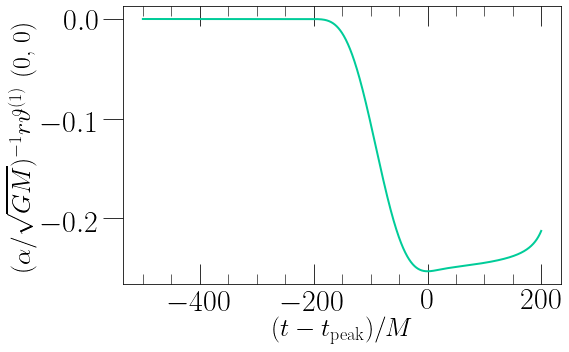

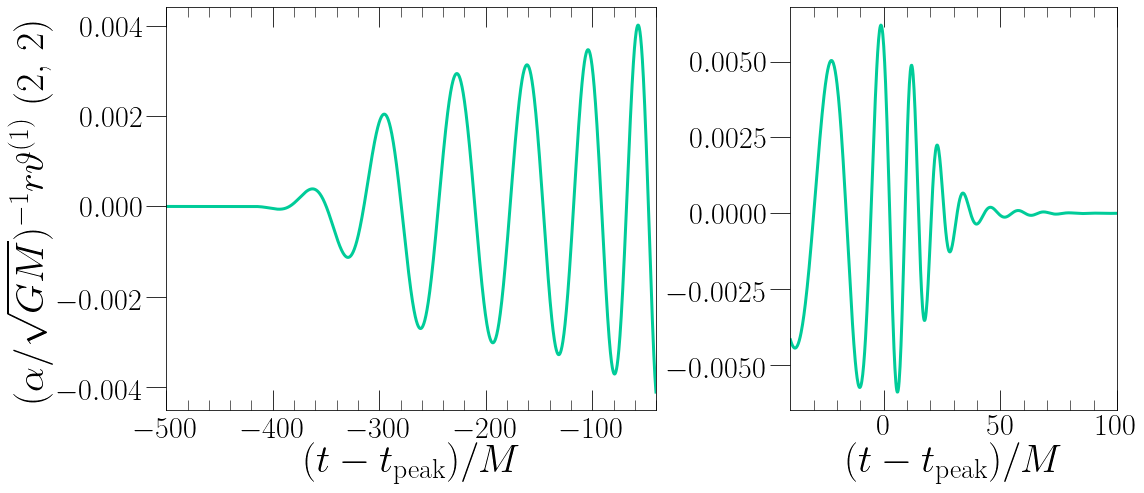

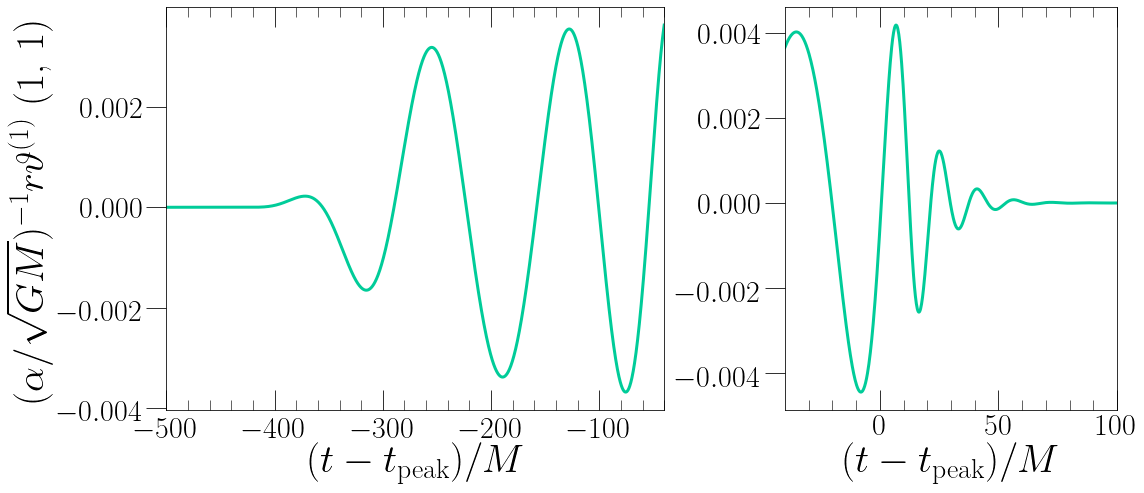

In [26]:
## Scalar field plots

def MakeNonRadiativeFieldPlot(start, radius=0): 

    GetMode = GetKGMode
    mode = (0,0)
    figname = 'KGPsi_' + str(mode[0]) + str(mode[1])
        
    fig, ax = plt.subplots(1, figsize=(8, 5))
    
    time, data = GetKGMode(ev_dir(start), mode=mode)
    time  = SubtractPeakTimeMode(time, data)
    time, data = CutTimes(time, data, -500, 200)

    ax.plot(time, np.real(data), color = ColorsDict[GetMode], lw=2.0, ls='-')
    
    ax.set_ylabel(LabelsDict[GetMode] + str(mode), fontsize=26)
    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=26) 
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

def ScalarFieldPlot(inspiral_start, mode): 

    figname = 'KGPsi_' + str(mode[0]) + str(mode[1])
        
    f = plt.figure(figsize=(16,7))
    gs = gridspec.GridSpec(1, 2,width_ratios=[1.5,1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    start = -500
    mid = -40
    end = 100
    
    time, data = GetKGMode(ev_dir(inspiral_start), mode=mode)
    time  = SubtractPeakTimeMode(time, data)

    time1, data1 = CutTimes(time, data, start, mid)
    time2, data2 = CutTimes(time, data, mid, end)
        
    ax1.plot(time1, np.real(data1), color = ColorsDict[GetKGMode], label='Re',lw=3.0)
    ax2.plot(time2, np.real(data2), color = ColorsDict[GetKGMode], label='Re',lw=3.0)

    ax1.set_xlim(start, mid)
    ax2.set_xlim(mid, end)
    ax1.set_ylabel(LabelsDict[GetKGMode] + str(mode), fontsize=40)
    ax1.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=40) 
    ax2.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=40) 
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

MakeNonRadiativeFieldPlot(2100)
ScalarFieldPlot(2100, (2,2))
ScalarFieldPlot(2100, (1,1))

2 2
400.413457673877
2 2
300.5341374297345
2 2
225.23859868642285
2 2
200.334795676486


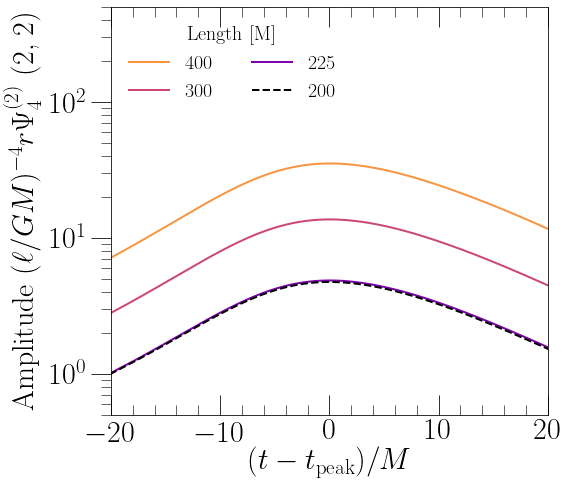

In [70]:
## Secular growth plots
def SecularRegimePlot(amplitude=False): 
    
    if not amplitude:
        start_arr = [1500, 1750, 1900, 2000, 2100]
        figname = 'SecularhPsi4'
        figsize=(10,6)
    else:
        start_arr = [1900, 2000, 2075, 2100]
        figname = 'AmplitudeSecularhPsi4'
        figsize=(8,7)

    cmap = matplotlib.cm.get_cmap('plasma')
    colors = [cmap(float(i)/len(start_arr)) for i in range(len(start_arr))][::-1]
        
    
    f, ax = plt.subplots(1, figsize=figsize)
    
    for start, color in zip(start_arr, colors):
        
        ## Get the extrapolated waveforms
        time, data = GethPsi4ModeExtrapolated(ex_dir(start, lev=0))
        ## Let's calculate the length until the merger time
        t_peak = GetPeakTimeMode(time, data)
        length = t_peak - start - 250 ## minus ramp time
        print(length)
        
        time = SubtractPeakTimeMode(time, data)
        #time, data = CutTimes(time, data, -500, -100)
        time, data = CutTimes(time, data, -100, 100)

        lw = 2.0
        ls='-'
        if start == start_arr[-1]:
            color = 'black'
            lw = 2.0
            ls='--'
        if amplitude:
            ax.plot(time, np.absolute(data), color = color, label="%d" % length, lw=lw,ls=ls)
        else:
            ax.plot(time, data, color = color, label="%d" % length, lw=lw, alpha=0.6)
    
    legend = ax.legend(fontsize=20, loc='lower left' if not amplitude else 'upper left', frameon=False, ncol=2 if amplitude else 1, \
              title='Length [M]')
    plt.setp(legend.get_title(),fontsize=20)
    if amplitude:
        ax.set_ylabel('Amplitude ' + LabelsDict[GethPsi4ModeExtrapolated] + str(mode), fontsize=30)
        ax.set_yscale('log')
        ax.set_ylim(5e-1, 5e2)
        ax.set_xlim(-20, 20)
    else:
        ax.set_ylabel('Re ' + LabelsDict[GethPsi4ModeExtrapolated] + str(mode), fontsize=30)
        #ax.set_xlim(-100, 100)
        
    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    #plt.ylim(-100, 100)
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

#SecularRegimePlot(amplitude=False)
SecularRegimePlot(amplitude=True)

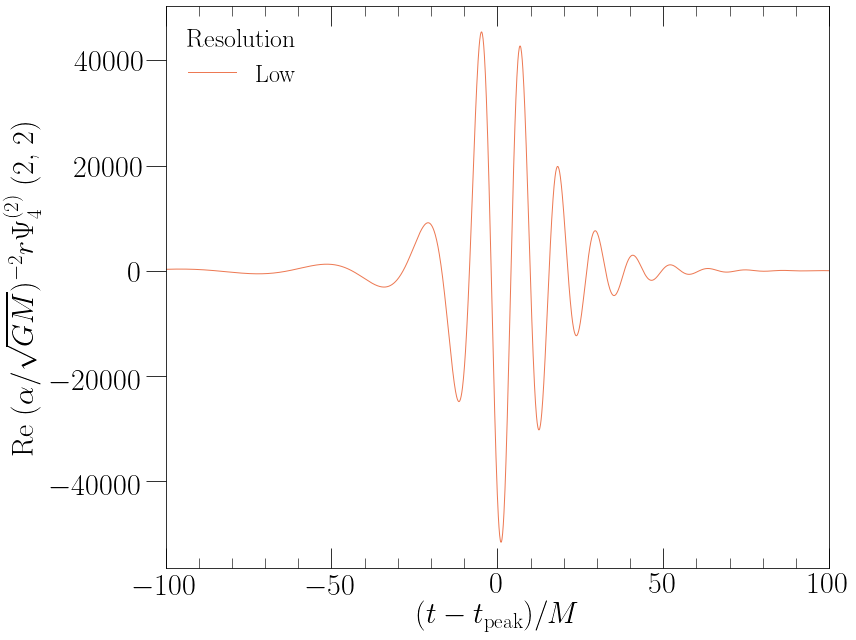

In [40]:
## Plot around t_s = 2100
def LIGOBucketPlot(): 
    
    figname = 'LIGOBuckethPsi4'

    cmap = matplotlib.cm.get_cmap('plasma')
    colors = [cmap(float(i)/3) for i in range(3)][::-1]
        
    f, ax = plt.subplots(1, figsize=(12,9))
    
    def GrabData(start, lev=0):
        time, data = GethPsi4Mode(ev_dir(start, lev=lev), radius=0)
        time = SubtractPeakTimeMode(time, data)
        time, data = CutTimes(time, data, -150, 150)  
        return time, data

    time, data = GrabData(2075, lev=0)
    #ax.plot(time, data, color = 'blue', label='Earlier start, Low', lw=1.0, ls='--',alpha=0.5)
 
    #time, data = GrabData(2075, lev=1)
    #ax.plot(time, data, color = 'blue', lw=0.5, alpha=1.0, ls='-',label='Earlier start, Med')
    
    ## Plot 2100 line and errors
    for lev, lab, color in zip([0, 1, 3], ['Low'], colors):
        time, data = GrabData(2100, lev=lev)
        
        ax.plot(time, data, alpha=1.0, label=lab,lw=1.0,color=color)


    legend = ax.legend(fontsize=24, loc='upper left', frameon=False, ncol=1, title='Resolution')
    plt.setp(legend.get_title(),fontsize=26)
    ax.set_ylabel('Re ' + LabelsDict[GethPsi4ModeExtrapolated] + str(mode), fontsize=30)
    ax.set_xlim(-100, 100)

    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

LIGOBucketPlot()


/Users/mokounkova/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


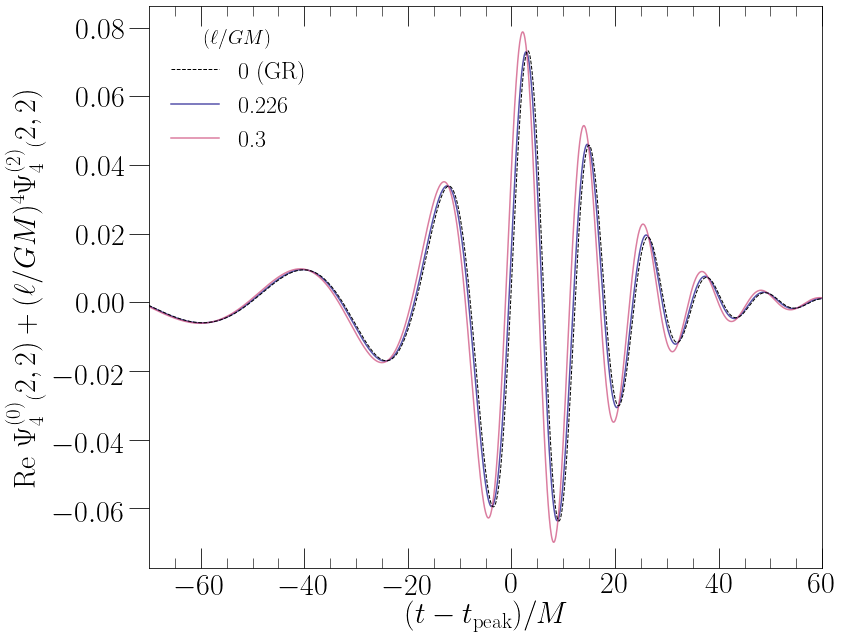

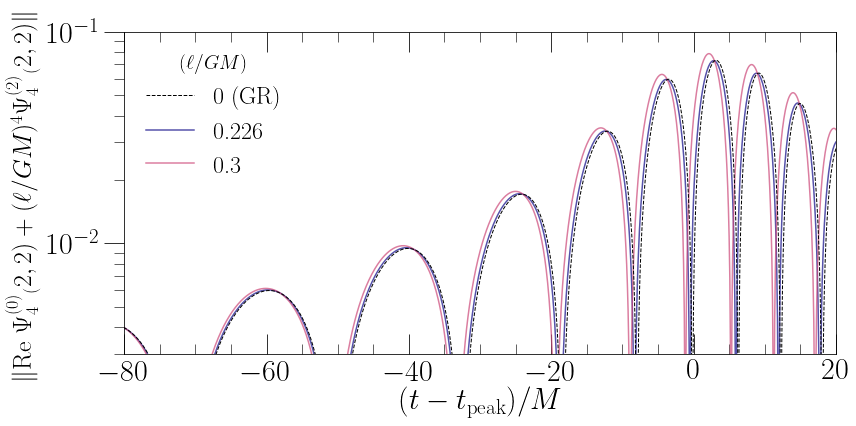

In [177]:
## GR and dCS together

def TogetherPlot(log=False): 
    
    figname = 'Together_log' if log else 'Together'
    
    cut_min = -100
    cut_max = 100
    lev = 0
        
    f, ax = plt.subplots(1, figsize=(12,6) if log else (12, 9))
    
    #time, data = GethPsi4Mode(ev_dir(2100, lev=lev))
    time, data = GethPsi4ModeExtrapolated(ex_dir(2100, lev=lev))
    t_peak = GetPeakTimeModeReal(time, data)
    time = SubtractPeakTimeModeReal(time, data)
    time, data = CutTimes(time, data, cut_min, cut_max)  
    
    #gr_time, gr_data = GetPsi4Mode(bev_dir(lev=lev))
    gr_time, gr_data = GetPsi4ModeExtrapolated(bex_dir(lev=lev))
    #gr_time = SubtractPeakTimeModeReal(gr_time, gr_data)
    gr_time = gr_time - t_peak
    gr_time, gr_data = CutTimes(gr_time, gr_data, cut_min, cut_max)

    ## Now get gr on the same axis
    gr_data = InterpolateTimes(gr_time, gr_data, time)
    
  
    l_arr = [0.226, 0.3]
    
    cmap = matplotlib.cm.get_cmap('plasma')
    colors = [cmap(float(i)/(len(l_arr))) for i in range(len(l_arr))]
    #colors = ['orange','purple']
    ax.plot([0,0], [0, 0], lw=1.0, ls='--', color='black',label='0 (GR)') ## for the laebl
    
    
    for l, color in zip(l_arr, colors):
        total = gr_data + l**4 * data
        ax.plot(time, abs(np.real(total)) if log else total, lw=1.5, label=l, color=color,alpha=0.7)
    ax.plot(time, abs(np.real(gr_data)) if log else gr_data, lw=1.0, ls='--', color='black')
       

    legend = ax.legend(fontsize=24, loc='upper left', frameon=False, ncol=1, title='$(\ell/GM)$')
    plt.setp(legend.get_title(),fontsize=20)
    ax.set_ylabel('Re $\Psi_4^{(0)} {}_(2,2) + (\ell/GM)^4 \Psi_4^{(2)} {}_(2,2)$' , fontsize=30)
    if log:
        ax.set_ylabel(r'$\|\textrm{Re }\Psi_4^{(0)} {}_(2,2) + (\ell/GM)^4 \Psi_4^{(2)} {}_(2,2)\|$' , fontsize=26)
    ax.set_xlim(cut_min, cut_max)
    if log:
        ax.set_ylim(3e-3, 1e-1)
        ax.set_xlim(-80, 20)
    else:
        ax.set_xlim(-70, 60)
    ax.set_xlabel('$(t - t_\mathrm{peak})/M$', fontsize=30) 
    if log:
        ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

TogetherPlot()
TogetherPlot(log=True)


In [84]:
## GR and dCS together

def Overlap(): 
    
    cut_min = -150
    cut_max = 150
    lev = 1
        
    time, data = GethPsi4ModeExtrapolated(ex_dir(2100, lev=lev))
    t_peak = GetPeakTimeModeReal(time, data)
    time = SubtractPeakTimeModeReal(time, data)
    time, data = CutTimes(time, data, cut_min, cut_max)  
    
    gr_time, gr_data = GetPsi4ModeExtrapolated(bex_dir(lev=lev))
    gr_time = gr_time - t_peak
    #gr_time = SubtractPeakTimeModeReal(gr_time, gr_data)
    gr_time, gr_data = CutTimes(gr_time, gr_data, cut_min, cut_max)
    
    ## Now get gr on the same axis
    gr_data = InterpolateTimes(gr_time, gr_data, time)
    
    l = 0.226
    
    total_data = gr_data + l**4 * data
    
    def product(d1, d2):
        return np.dot(d1, np.conj(d2))
    
    denom = np.sqrt(product(total_data, total_data) * product(gr_data, gr_data))
    numerator = product(total_data, gr_data)
    mismatch = np.real(numerator/denom)
    
    
    print(numerator)
    print(denom)
    print(mismatch)


Overlap()


(1.2871793984006747-0.1564896976455048j)
(1.2973427857876834+0j)
0.9921659969143484


In [180]:
## QNM perturbation theory results

def PerturbationTheoryResult(mode, spin):
    """ Returns analytical result for a given run with initial spins
        spin, for a given mode"""

    L = mode[0]
    M = mode[1]
    N = mode[2]
    mode_nums = [(-2, L, M, N)]
    modes = [ksc(*mode_num) for mode_num in mode_nums]
    chi_f = spin

    omega_times_M = [np.real(mode(chi_f)[0]) for mode in modes][0] # List of omegas
    tau_over_M = [-1./np.imag(mode(chi_f)[0]) for mode in modes][0] # List of taus
 
    # returns the true omega and the tau, without factors of m around  
    return omega_times_M / mfinal, tau_over_M * mfinal

PerturbationTheoryResult((2,2,0), spin_final)

(0.5553577502777438, 11.744856537345408)

[ -0.34575895   3.79373228  -1.30922608  -7.39930131 213.17382136
 139.31495235]
[ -0.46956861   4.07693717  -1.58473184  -8.38826718 227.46841461
 153.32549538]
[ -0.43716334   3.92357794  -1.53638086  -8.1367153  220.95001723
 146.96053452]


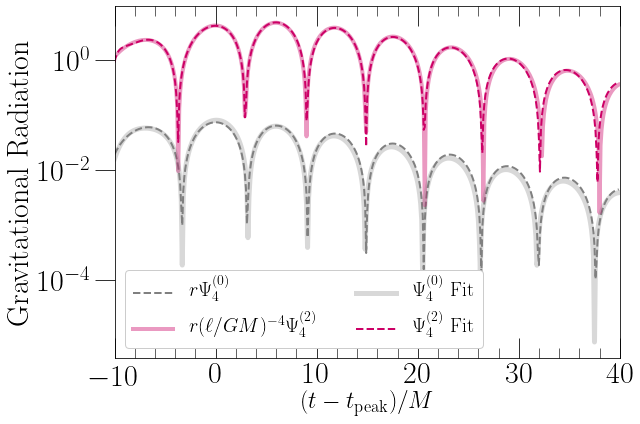

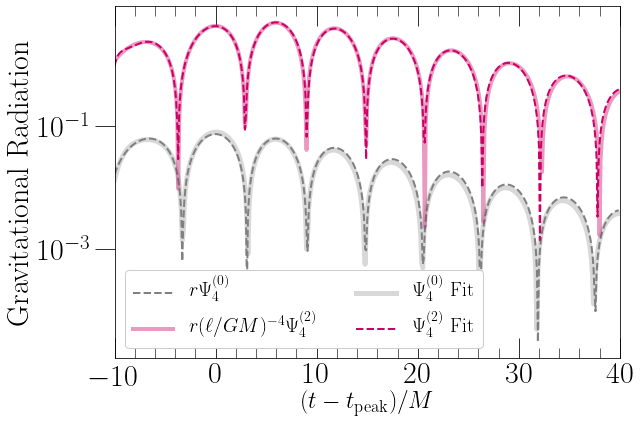

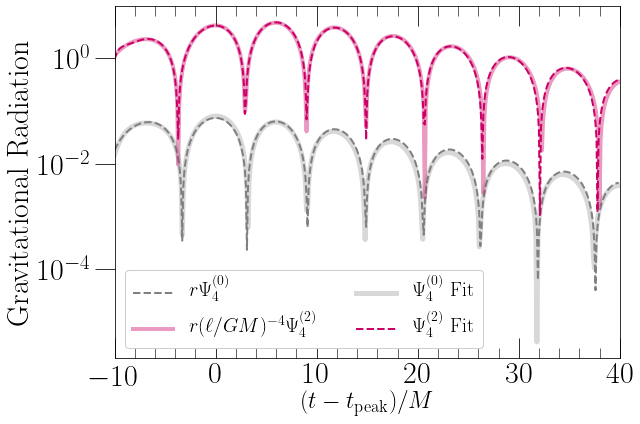

In [199]:
## QNM fits

def QNMFitOvertones(time, waveform, mode=(2,2)):
    """ Fits 3 GR overtones to a given mode of 
        a background gravitational waveform ringdown """
    
    L = mode[0]
    M = mode[1]
    
    def tone(t, A, delta, N):
        omega, tau = PerturbationTheoryResult((L,M,N-1), spin_final)
        ## Use the real part to get A and delta for each of the overtones
        P = A*np.exp(-t/tau)*np.cos(-t*omega + delta)
        return P

    def tone_func(t, A1, A2, A3, delta1, delta2, delta3):
        t = t - t[0]

        P1 = tone(t, A1, delta1, 1)
        P2 = tone(t, A2, delta2, 2)
        P3 = tone(t, A3, delta3, 3)
        
        return P1 + P2 + P3 
    
    popt, pcov = curve_fit(tone_func, time, waveform, maxfev = 40000)
    fit = tone_func(time, *popt)
    return time, fit, popt

def QNMFitOvertonesPert(time, waveform, delta_waveform, mode=(2,2)):
    """ Fits 3 perturbed overtones to a dCS (or general)
        waveform perturbation delta_waveform, using the 
        background GR waveform in order to get the background parameters """
    
    L = mode[0]
    M = mode[1]
    
    aa, aa, background_popt = QNMFitOvertones(time, waveform)
    A1 = background_popt[0]
    A2 = background_popt[1]
    A3 = background_popt[2]
    delta1 = background_popt[3]
    delta2 = background_popt[4]
    delta3 = background_popt[5]
    
    def perturbed_tone(t, A, delta, Delta_A, Delta_delta, Delta_omega, Delta_tau, N):
        """ Perturbation to a QNM """
        
        Delta_delta = 0.0
        
        omega, tau = PerturbationTheoryResult((L,M,N-1), spin_final)

        t = t - t[0]
        
        arg = -t*omega + delta
        
        Constant_Piece = Delta_A*np.cos(arg) #- A*Delta_delta*np.sin(arg)
        Linear_Coeff = Delta_tau/tau**2*A*np.cos(arg) + A*np.sin(arg)*Delta_omega
        
        return (Constant_Piece + t*Linear_Coeff)*np.exp(-t/tau)
    
    
    def tone_func(t, Delta_A1, Delta_A2, Delta_A3, \
                  Delta_delta1, Delta_delta2, Delta_delta3, \
                  Delta_omega1, Delta_omega2, Delta_omega3, Delta_tau1, Delta_tau2, Delta_tau3):
        t = t - t[0]

        ## Since I am sending (1, 2, 3) and want the tones (0, 1, 2), I use N-1 for the 
        ## Perturbation theory result call
        P1 = perturbed_tone(t, A1, delta1, Delta_A1, Delta_delta1, Delta_omega1, Delta_tau1, 1)
        P2 = perturbed_tone(t, A2, delta2, Delta_A2, Delta_delta2, Delta_omega2, Delta_tau2, 2)
        P3 = perturbed_tone(t, A3, delta3, Delta_A3, Delta_delta3, Delta_omega3, Delta_tau3, 3)
        return P1 + P2 + P3 
    
    popt, pcov = curve_fit(tone_func, time, delta_waveform, maxfev = 40000)
    fit = tone_func(time, *popt)
    
    return time, fit, popt[6:]

def PlotMetricPerturbationFit(lev=0):     

    figname = 'RDFit'
    f, ax = plt.subplots(1, figsize=(9,6))
    
    inspiral_start_time = 2100 ## inspiral start time of data we'll be using
    start = -10
    end = 40

    ## Get the dCS data
    dcs_time, dcs_data = GethPsi4ModeExtrapolated(ex_dir(inspiral_start_time))
    dcs_data = np.real(dcs_data) ## grab the real part
    t_peak = GetPeakTimeModeReal(dcs_time, dcs_data)
    
    dcs_time = SubtractPeakTimeModeReal(dcs_time, dcs_data)
    dcs_time, dcs_data = CutTimes(dcs_time, dcs_data, start, end)
    
    ## Get background data
    time, data = GetPsi4ModeExtrapolated(bex_dir(lev=lev))
    data = np.real(data) ## grab the real part
    ## Subtract the peak time
    #time = time - t_peak
    time =  SubtractPeakTimeModeReal(time, data)
    time, data = CutTimes(time, data, start, end)

    
    
    ## interpolate the background waveform onto the dCS axis
    data = InterpolateTimes(time, data, dcs_time)
    
    ax.plot(dcs_time, np.abs(data), color = 'gray', ls='--', lw = 2.0, label=r'$r\Psi_4^{(0)}$')
    ax.plot(dcs_time, np.abs(dcs_data), lw = 4.0, \
               label='$r(\ell/GM)^{-4}  \Psi_4^{(2)}$ ', alpha=0.4, color = ColorsDict[GethPsi4Mode])
    
    timefit, fit, popt = \
        QNMFitOvertones(dcs_time, data)
    ax.plot(timefit, np.abs(fit), lw=5.0, color = 'gray', label='$\Psi_4^{(0)}$ Fit', alpha=0.3)

    delta_timefit, delta_fit, popt = \
       QNMFitOvertonesPert(dcs_time, data, dcs_data)
    print(popt)
    ax.plot(delta_timefit, np.abs(delta_fit), color = ColorsDict[GethPsi4Mode], \
           ls='--', lw=2.0, label='$\Psi_4^{(2)}$ Fit')
        
    ax.set_yscale('log')
    ax.set_ylabel('Gravitational Radiation', fontsize=30)
    plt.xlim(start, end)
    ax.legend(loc='lower left', framealpha=1.0, frameon=True, fontsize=20, ncol=2)
    ax.set_xlabel('$(t - t_\mathrm{peak})/M$') 
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    #plt.show()     


PlotMetricPerturbationFit(lev=0)
PlotMetricPerturbationFit(lev=1)
PlotMetricPerturbationFit(lev=2)

In [ ]:
## Post-Newtonian calculation

def PNComparison(): 
    
    figname = 'PostNewtonian'
        
    f, ax = plt.subplots(1, figsize=(16,7))
      
    ## Background waveform
    time, data = GetPsi4ModeExtrapolated(bex_dir(), mode=(2,2))
    time = SubtractPeakTimeMode(time, data)
    time, data = CutTimes(time, data, -2000, -50)
    
    ## Get frequency of the 2,2 mode for the orbital frequency
    amp, phase = AmpPhase(time, data)
    freq = Freq(time, data)
    
    ## the frequency of the background waveform is 2 * omega, 
    ## where omega is the orbital frequency. This, however, is precisely 
    ## the quantity that we need for the PN calculation.  So we  can thus use
    ## the background gravitational wave phase
    
    ## Compute the PN coefficient
    ## The total mass M = 1
    ## beta = 1 (see scalar field paper)
    ## Recall that everything is rPsi4
    mpl =  1.0/sqrt(8.0*pi)
    numerical_coeff = pi**(3/2) * 25.0 / (8.0 *  sqrt(5.0)) *  mpl**2
    ## numerical coeff if O(0.1)
    coeff = numerical_coeff * chi_1 * chi_2 
    amplitude = coeff * freq**4
    
    PN_result = amplitude * np.exp(1j*phase) 
    
    #plt.plot(time, data)
    plt.plot(time, PN_result, color='purple', ls='-', label='$r \Psi_4^{(2)}{}_\mathrm{PN} (2, 2) / \ell^4$', lw=5.0)
    
    plt.xlabel('$(t - t_\mathrm{peak})/M$', fontsize=40)
    plt.legend(loc='upper left', frameon=False, fontsize=40)
        
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

PNComparison()

/Users/mokounkova/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide


2100 0.04103430539691684


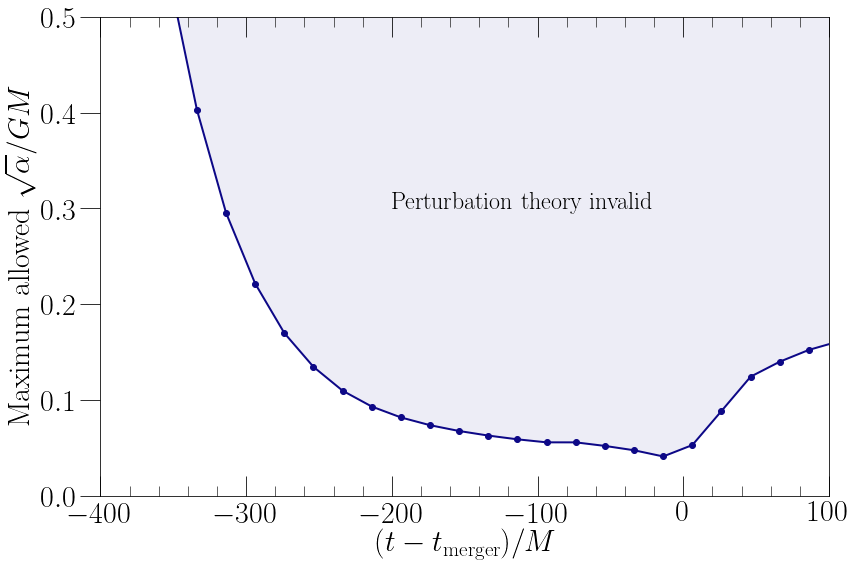

In [24]:
## Regime of validity

def ComputeEpsilon(p):
    filename = p + 'Validity.dat'
    Time = []
    Validity = []
    C4 = 0.1**(1.0/4.0) ## fourth root of the tolerance factor, from the previous notebook
    
    for line in open(filename):
        li=line.strip()
        if not li.startswith("#"):
            A = li.split()
            a = np.array(A).astype(np.float)
            Time.append(a[0])
            if a[0] > t_merger:
                Val = sorted(a[1:])[::-1][1]
            else:
                Val = sorted(a[1:])[::-1][2]
            ## Correct for the B factor -- in the code we make delta psi articificially small by
            ## multiplying it by B < 1, so here we need to divide by this B to make it big again
            ## recall Val is like delta psi / psi 
            B = 0.1 
            #print(Val)
            Val = Val / B 
            Validity.append(Val)

    Time = np.array(Time)
    Time = Time - t_merger
    ## Validity is the pointwise \Delta g / g
    ## so we need 
    
    ## Apply the transformation
    ## We want the minimum, which is 1/ the maximum
    ## Assume that the only thing we're doing to the metric is a factor of alpha and beta
    ## Right now going to do sqrt(alpha)/GM as our measure
    Epsilon = C4  * (np.divide(1.0, Validity))**(1.0/4.0)
    #print(Epsilon)
 
    return Time, Epsilon 


def PlotValidity(figname):  
    
    figname = 'Validity'
    
    start_arr = ['2100']
    ramp = 250 ## ramp length

    cmap = matplotlib.cm.get_cmap('plasma')
    colors = [cmap(float(i)/len(start_arr)) for i in range(len(start_arr))][::-1]
        
    f, ax = plt.subplots(1, figsize=(12,8))
    
    for start, color in zip(start_arr, colors):
        
        time, eps = ComputeEpsilon(ev_dir(start))
        # Cut the time so only considering dCS effects
        time, eps = CutTimes(time, eps, -400, 200)
        print (start, min(eps))
        ax.plot(time, eps, '-o', color = color, label=start, lw=2.0)
        
        ax.fill_between(time, eps, 2.0, color=color,alpha=0.07)

        
    #legend = ax.legend(fontsize=20, loc='upper left', frameon=True, framealpha = 1.0, ncol=1, \
    #          title='Start time $[M]$')
    #plt.setp(legend.get_title(),fontsize=20)
    ax.text(-200, 0.3, 'Perturbation theory invalid', fontsize=24, color='black')
    ax.set_xlabel('$(t - t_\mathrm{merger})/M$', fontsize=30) 
    ax.set_ylabel(r'Maximum  allowed $\sqrt{\alpha}/GM$', fontsize=30)
    ax.set_xlim(-400, 100)
    ax.set_ylim(0.0, 0.5)
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()     

    
PlotValidity('Validity.pdf')
